In [1]:
import os
import glob
import rosbag
import pandas as pd
import numpy as np
import cv2
import time 

import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt

from os import path
from utils.visualisation import *
from utils.postprocessing.utils import csvs2dfs
from functools import reduce
from utils.postprocessing.config import Config
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual


/home/francesco/.local/lib/python3.6/site-packages/skimage/novice/__init__.py:103: UserWarning: The `skimage.novice` module was deprecated in version 0.14. It will be removed in 0.16.
  warnings.warn("The `skimage.novice` module was deprecated in version 0.14. "


In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [ ]:
%%html
<style>

.div.output_scroll {
    height : auto;
}
</style>

# Visualize the simulation
Visualize the robot's simulation on a specific map is tremendously to understand if everything went perfect. Also, we can have an idea about the generated dataset.

In [16]:
MAP_NAME = 'slope_rocks1'
MAPS_DIR = '/home/francesco/Documents/Master-Thesis/core/maps/train/'

In [17]:
csvs_paths = glob.glob('/home/francesco/Desktop/carino/vaevictis/data/train/csvs/{}/*.csv'.format(MAP_NAME))
# csvs_paths = glob.glob('/home/francesco/Desktop/data/csv/querry/*.csv')
len(csvs_paths)

89

In [18]:
hm = cv2.imread('{}/{}.png'.format(MAPS_DIR, MAP_NAME))
hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)

In [19]:
dfs = csvs2dfs(csvs_paths)

## Visualize the robot's trace
Below we plotted all the robot's positions for the given map

In [20]:
dfs = csvs2dfs(csvs_paths)

## Plotting statistics

In [109]:
df_total = pd.concat(filter(lambda x: len(x) > 0, dfs))
df_total = df_total.dropna()
df_total = df_total.reset_index() # we need to reset the index otherwise the plots are based on the old overlapping indexes

### Advancement
Below we show a box plot of the advancement

<IPython.core.display.Javascript object>


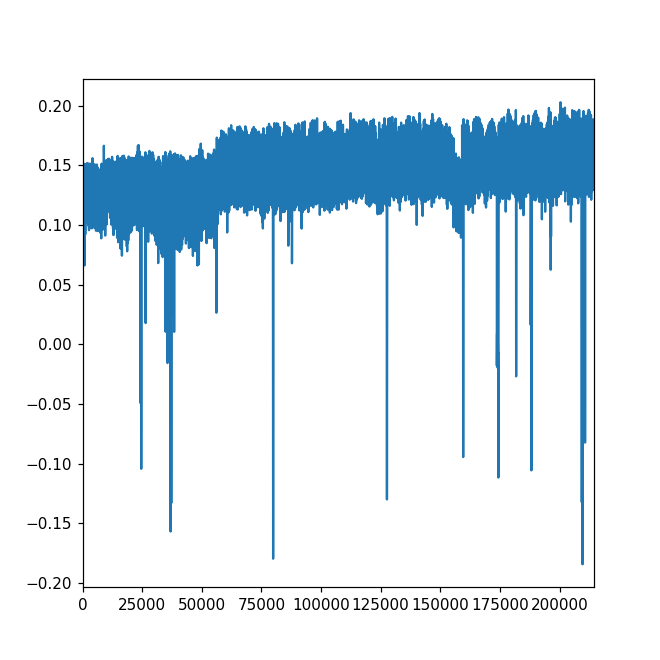

In [110]:
fig = plt.figure()
df_total['advancement'].plot.line()

In [12]:
fig = plt.figure()
df_total['advancement'].plot.box()
df_total['advancement'].mean()

<IPython.core.display.Javascript object>

0.138174578732868

In [13]:
df_total['advancement'].min()

-0.1842106711187837

# Debug

In [40]:
from utils.visualisation import *
from utils.postprocessing.utils import *
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib import gridspec


In [107]:
class DebugPipeline():
    def __init__(self, hm):
        self.hm = hm
        self.patch_size = 100 // 2
    
    @property
    def hm_ax(self):
        fig = plt.figure()
        ax = sns.heatmap(hm)
        return ax 
    
    def show_map(self, hm):
        self.hm_ax
        plt.show()
            
    def show_traces(self, dfs, ax=None):
        if ax is None: ax = self.hm_ax
        
        start_marker = mlines.Line2D([], [],marker='o', color='g', ls='', label='start')
        finish_marker = mlines.Line2D([], [],marker='o', color='r', ls='', label='finish')

        for df in dfs:
            initial_pos = df.hm_x.iloc[0], df.hm_y.iloc[0]
            last_position = df.hm_x.iloc[-1], df.hm_y.iloc[-1]
            ax.plot(*initial_pos, marker='o', color='g', ls='', label='start')
            ax.plot(*last_position, marker='o', color='r', ls='', label='finish')
            ax.plot(df.hm_x,  df.hm_y, '--', linewidth=2, color='white', label='path')
            
        ax.legend(handles=[start_marker, finish_marker])

        return ax
    
    def show_patches(self, df, center=False, n_samples=4, scale=1, random_state=0):
        sample = df.sample(n_samples, random_state=random_state)
        fig, ax = plt.subplots(nrows=n_samples // 2, ncols=n_samples // 2)
        fig.suptitle('patches center={}'.format(center))
        for row in ax:
            for idx, (col, (i, row)) in enumerate(zip(row, sample.iterrows())):
                x, y = row["hm_x"],row["hm_y"]
                patch, _ = hmpatch(self.hm, x, y,np.rad2deg(row['pose__pose_position_z']),  self.patch_size,scale=1)
                patch = patch.astype(np.float32)
                if center: patch = patch - patch[patch.shape[0] // 2, patch.shape[1] // 2]                    
                col.plot(self.patch_size // 2, self.patch_size // 2, marker='o', color='r', ls='', linewidth=10, label='finish')                
                sns.heatmap(patch, ax=col)
        
        plt.show()
        
        
#     def show_patch_on_the_map(self, sample):
#         fig = plt.figure(figsize=(6, 12))
        
        
#         x, y, ang, ad = sample["hm_x"], \
#             sample["hm_y"], \
#             sample['pose__pose_position_z'], \
#             sample["advancement"]

#         ax1 = plt.subplot(2, 1, 1)
#         ax2 = plt.subplot(2, 1, 2)
                
#         ax1.set_title("advancement: {:.4f}, x={:.0f}, y={:.0f}".format(ad, 
#                                                                       x,
#                                                                       y))
#         sns.heatmap(self.hm, ax=ax1)
#         rect = patches.Rectangle((x -  self.patch_size // 2,y -  self.patch_size // 2), self.patch_size, 
#                                  self.patch_size, linewidth=1, edgecolor='r', facecolor='none')
#         ax1.add_patch(rect)
    
#         patch, _ = hmpatch(self.hm, x, y,np.rad2deg(ang),  self.patch_size ,scale=1)
#         sns.heatmap(patch, ax=ax2)
        
    
    def show_patch_on_the_map(self, sample):
        fig = plt.figure(figsize=(6, 12))


        x, y, ang, ad = sample["hm_x"], \
            sample["hm_y"], \
            sample['pose__pose_position_z'], \
            sample["advancement"]
        
        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2)

        ax1.set_title("advancement: {:.4f}, x={:.0f}, y={:.0f}".format(ad, 
                                                                      x,
                                                                      y))
        sns.heatmap(self.hm, ax=ax1)
        rect = patches.Rectangle((x -  self.patch_size // 2,y -  self.patch_size // 2), self.patch_size, 
                                 self.patch_size, linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)

        patch, _ = hmpatch(self.hm, x, y,np.rad2deg(ang),  self.patch_size ,scale=1)
        sns.heatmap(patch, ax=ax2)

        
    def show_patches_on_the_map(self, df):
        n_show = 4

        fig = plt.figure(figsize=(12,12))
        
        size = (2 + n_show//2 , 2 + n_show//2)
        gridspec.GridSpec(*size)
        
        ax_hm = plt.subplot2grid((size), (0,0), colspan=2, rowspan=2)
        
        sns.heatmap(self.hm / 255, ax=ax_hm)

        self.show_traces([df], ax=ax_hm)
        
        subset = df.loc[list(range(0, len(df), len(df) // n_show)), :]
        print(list(range(0, len(df), len(df) // n_show)))
        hm_patches = []
        for i, row in subset.iterrows():
            x, y, ang, ad = row["hm_x"], \
            row["hm_y"], \
            row["pose__pose_position_z"], \
            row["advancement"]
            rect = patches.Rectangle((x -  self.patch_size // 2,y -  self.patch_size // 2), self.patch_size, 
                                 self.patch_size, linewidth=1, edgecolor='r', facecolor='none')
            ax_hm.add_patch(rect)
        
            patch, _ = hmpatch(self.hm, x, y,np.rad2deg(ang),  self.patch_size ,scale=1)
            hm_patches.append(patch)
        
        for i in range(n_show//2):
            for j in range(n_show//2):
                ax_patch = plt.subplot2grid((size), (2 + i, j), colspan=1, rowspan=1)
                sns.heatmap(hm_patches[i + j], ax=ax_patch)
#             self.show_patch_on_the_map(sample[1])
            
    def show_traversability_in_time(self, df, dt=100):
        fig = plt.figure()
        plt.title('advancement')
        plt.plot( df.index, df['advancement'])
        plt.show()
    
    
    def plot_rotation(self, df):
        fig = plt.figure()
        plt.title('rotation')
        ax1 = plt.subplot(3, 1, 1)
        ax2 = plt.subplot(3, 1, 2)
        ax3 = plt.subplot(3, 1, 3)
        ax1.set_title('yaw')
        df['pose__pose_e_orientation_x'].plot(ax=ax1)
        ax3.set_title('pitch')
        df['pose__pose_e_orientation_y'].plot(ax=ax2)
        ax3.set_title('roll')
        df['pose__pose_e_orientation_z'].plot(ax=ax3)
        plt.legend()
        
    def plot_position(self, df):
        fig = plt.figure()
        plt.title('position')
        df['pose__pose_position_x'].plot(label='x')
        df['pose__pose_position_y'].plot(label='y')
        plt.legend()
        
        
    def __call__(self, df, dt=100):
        self.show_patches_on_the_map(df)
        self.plot_rotation(df)
        self.plot_position(df)
        self.show_traversability_in_time(df)
        
        

In [108]:
deb_pip = DebugPipeline(hm)

def csv_path2debug(csv_path):
    idx = csvs_paths.index(csv_path)
    deb_pip(dfs[idx])
    

interact(csv_path2debug, csv_path=csvs_paths);

interactive(children=(Dropdown(description='csv_path', options=('/home/francesco/Desktop/carino/vaevictis/data…

In [42]:

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [38]:
%%html
<style>

.div.output_scroll {
    height : auto;
}
</style>

In [39]:
deb_pip = DebugPipeline(hm)

def csv_path2debug(csv_path):
    idx = csvs_paths.index(csv_path)
    deb_pip(dfs[idx])
    

interact(csv_path2debug, csv_path=csvs_paths);

interactive(children=(Dropdown(description='csv_path', options=('/home/francesco/Desktop/carino/vaevictis/data…

# Debug our coordinate function

This is krock on the simulator

![alt]("./images/bars1_krock.jpg")


In [ ]:
def to_hm_coordinates(row, hm, res, tr=[0, 0]):
    x, y = row['pose__pose_position_x'], row['pose__pose_position_y']
    x_max, y_max = hm.shape[0] * res, hm.shape[1] * res
    x_min, y_min = tr

    xs = x + x_min
    ys = -y + y_min

    return pd.Series([xs / res, ys / res])